EBM(Energy Based Model)

In [1]:
# 볼츠만분포 를 사용해서 실제 데이터의 생성분포를 모델링
# E(x) 샘플 x의 에너지 함수(점수)
# 훈련을 통해 가능성이 높은 샘플에는 낮은 점수를 출력 p(x)는 1에 가까워진다
# 낮은  셈플에는 높은점수를 출력 p(x)는 0에 가까워진다

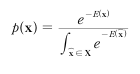

In [2]:
# 문제점을 개선 : 2019년도 논문 Implicit Generatioin and Modeling with Energy-Based Models 아이디어를 채용

In [10]:
# 데이터 셋  MNIST 데이터셋
from tensorflow.keras import datasets
(x_train,y_train), (x_test,y_test) = datasets.mnist.load_data()


In [11]:
x_train.shape

(60000, 28, 28)

In [12]:
# 효율적이 학습을 위해서 픽셀값을 [-1,1] 조정하고 32X32픽셀로 패딩 추가
# 데이터 정규화 : 보통 이미지데이터는 0~1사이의 값으로 표현, -1 ~ 1로 조정을 하면 중앙 0 주변에 데이터가 분포해서
# 신경망이 더 빠르게 학습하고 안정적으로...
# 32 32 패딩추가 : 원래는 28 28 -> 32 32 입력크기를 조정(패딩을 추가) --> 모델이 미묘한 특징을 감지하는데 도움

In [13]:
# 전처리
import numpy as np
def preprocess(imgs):
  imgs = (imgs.astype('float32') - 127.5) / 127.5
  imgs = np.pad(imgs, ( (0,0), (2,2),(2,2)), constant_values = -1.0)
  imgs = np.expand_dims(imgs,-1)
  return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)
x_train.shape

(60000, 32, 32, 1)

In [14]:
import tensorflow as tf
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(128)

In [18]:
next(iter(x_train)).shape, next(iter(x_test)).shape

(TensorShape([128, 32, 32, 1]), TensorShape([128, 32, 32, 1]))

In [ ]:
# 에너지함수 : 파라미터가 쎄타이고 입력이미지 x를 하나의 스칼라값으로 변환하는 신경망
# 이걸 위해서 활성화함수로 swixh(스위시)사용

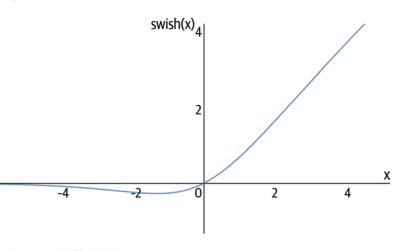

In [ ]:
# 스위시 함수는 Relu대안 2017년도 구글에서 소개

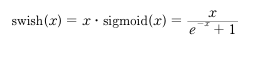

In [19]:
from tensorflow.keras import(
    layers,models,optimizers,activations,metrics,callbacks
)

In [21]:
ebm_input = layers.Input(shape=(32,32,1))
x = layers.Conv2D(16,kernel_size = 5,strides=2,padding='same',activation = activations.swish)(ebm_input)
x = layers.Conv2D(32,kernel_size = 3,strides=2,padding='same',activation = activations.swish)(x)
x = layers.Conv2D(64,kernel_size = 3,strides=2,padding='same',activation = activations.swish)(x)
x = layers.Conv2D(64,kernel_size = 3,strides=2,padding='same',activation = activations.swish)(x)
x = layers.Flatten()(x)
x = layers.Dense(64,activation =activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input,ebm_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        416       
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                1644

In [ ]:
# 에너지 함수 : 입력에 대해서 하나의 점수만 출력, 에너지 점수가 낮은 새로운 샘플을 생성?
# 에너지 함수 기울기를 계산--> Langevin dynamics  랑주뱅 다이나믹기법을 이용해서 그레이디언트 계산
# 경사하강법과 차이가 있다
# 신경망의 가중치를 고정한상태에서 입력대비 출력에 대한 기울기(미분)를 계산 -> 음의방향으로 조금씩 업데이트

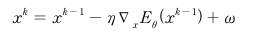

In [ ]:
# Langevin dynamics를 사용해서 셈플을 생성하는 함수 - 무작위 노이즈와 그레이디언트를 활용